In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install tensorflow matplotlib scikit-learn

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os, shutil, random

def split_dataset(base_dir, output_dir, train_ratio=0.8, val_ratio=0.1):
    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        images = os.listdir(cls_path)
        random.shuffle(images)

        train_count = int(len(images) * train_ratio)
        val_count = int(len(images) * val_ratio)

        split_paths = {
            'train': os.path.join(output_dir, 'train', cls),
            'val': os.path.join(output_dir, 'val', cls),
            'test': os.path.join(output_dir, 'test', cls)
        }

        # Create directories
        for path in split_paths.values():
            os.makedirs(path, exist_ok=True)

        # Copy files
        for i, img in enumerate(images):
            src = os.path.join(cls_path, img)
            if i < train_count:
                dst = os.path.join(split_paths['train'], img)
            elif i < train_count + val_count:
                dst = os.path.join(split_paths['val'], img)
            else:
                dst = os.path.join(split_paths['test'], img)
            shutil.copy(src, dst)

# Set paths
source = '/content/drive/MyDrive/garbage_dataset'
destination = '/content/drive/MyDrive/garbage_split'

split_dataset(source, destination)


In [6]:
# Set image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Set directory paths
train_dir = '/content/drive/MyDrive/garbage_split/train'
val_dir = '/content/drive/MyDrive/garbage_split/val'
test_dir = '/content/drive/MyDrive/garbage_split/test'


In [7]:
# For training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# For validation and test (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [8]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2019 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Found 257 images belonging to 6 classes.


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load base model (no top layer, pretrained on ImageNet)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # 6 classes
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.2402 - loss: 1.9273 - val_accuracy: 0.5538 - val_loss: 1.2100
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4724 - loss: 1.3741 - val_accuracy: 0.6494 - val_loss: 0.9667
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5387 - loss: 1.1774 - val_accuracy: 0.6972 - val_loss: 0.8345
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6384 - loss: 0.9691 - val_accuracy: 0.7131 - val_loss: 0.7573
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6321 - loss: 0.9476 - val_accuracy: 0.7689 - val_loss: 0.7015
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6781 - loss: 0.8821 - val_accuracy: 0.7729 - val_loss: 0.6603
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.6988 - loss: 0.8179 - val_accuracy: 0.7769 - val_loss: 0.6288
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.6874 - loss: 0.7937 - val_accuracy: 0.7928 - v

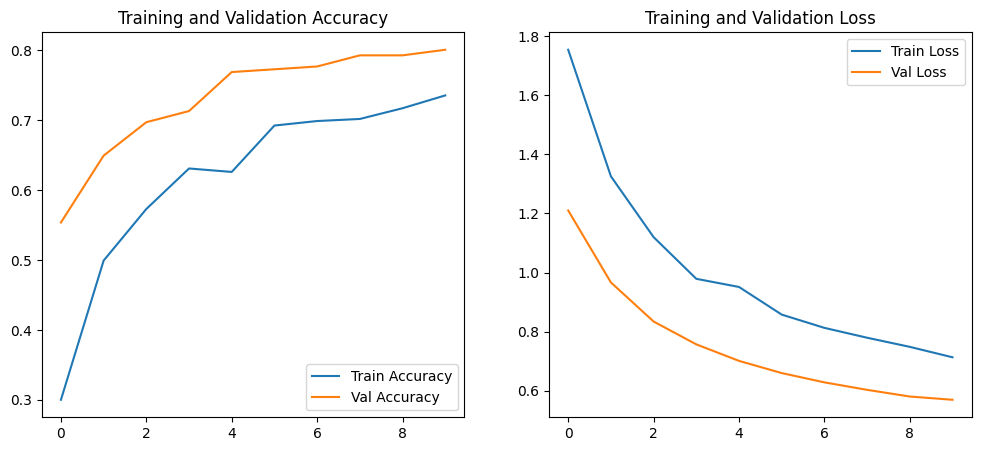

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [14]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7905 - loss: 0.5189
Test Accuracy: 75.88%


9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
              precision    recall  f1-score   support

   cardboard       0.90      0.90      0.90        41
       glass       0.66      0.65      0.65        51
       metal       0.82      0.80      0.81        41
       paper       0.84      0.88      0.86        60
     plastic       0.65      0.67      0.66        49
       trash       0.50      0.40      0.44        15

    accuracy                           0.76       257
   macro avg       0.73      0.72      0.72       257
weighted avg       0.76      0.76      0.76       257



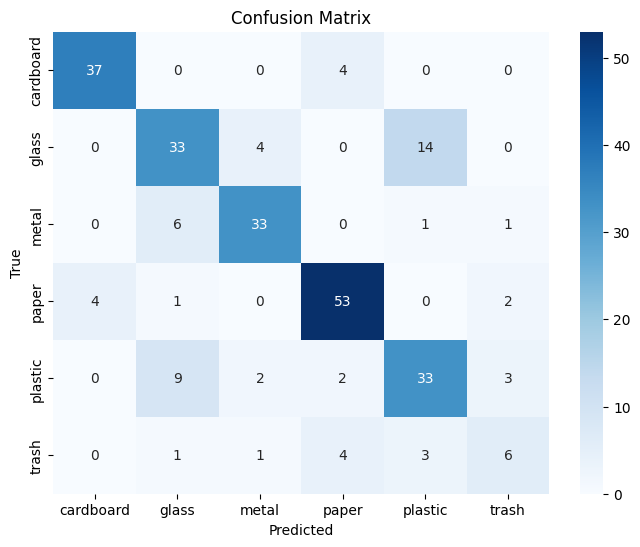

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict test data
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
true_labels = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Classification report
print(classification_report(true_labels, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# Unfreeze the base model
base_model.trainable = True

# Compile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_epochs = 5
history_fine = model.fit(
    train_data,
    epochs=fine_tune_epochs,
    validation_data=val_data
)


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 520s 7s/step - accuracy: 0.4947 - loss: 1.4037 - val_accuracy: 0.8127 - val_loss: 0.5882
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 467s 7s/step - accuracy: 0.5924 - loss: 1.0399 - val_accuracy: 0.8088 - val_loss: 0.6063
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 455s 7s/step - accuracy: 0.6382 - loss: 0.9271 - val_accuracy: 0.8127 - val_loss: 0.6106
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 454s 7s/step - accuracy: 0.6840 - loss: 0.8379 - val_accuracy: 0.8008 - val_loss: 0.6104
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 459s 7s/step - accuracy: 0.6998 - loss: 0.7836 - val_accuracy: 0.7968 - val_loss: 0.6005


In [17]:
model.save('garbage_classifier_mobilenetv2.h5')

In [18]:
model.save("garbage_classifier.keras")


In [19]:
from google.colab import files
uploaded = files.upload()


Saving glass_009.jpg to glass_009.jpg


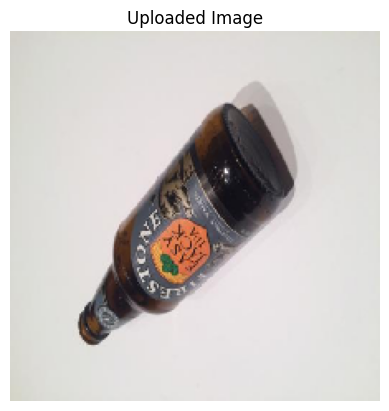

In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Replace 'example.jpg' with your uploaded image filename
img_path = 'glass_009.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

In [21]:
# Make prediction
pred = model.predict(img_array)
class_index = np.argmax(pred)

# Get class labels from the training data generator
class_labels = list(train_data.class_indices.keys())

# Print prediction
print(f"Predicted Class: {class_labels[class_index]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: glass


In [22]:
from google.colab import drive
drive.mount('/content/drive')

# Move model to Drive
!cp garbage_classifier.keras /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
